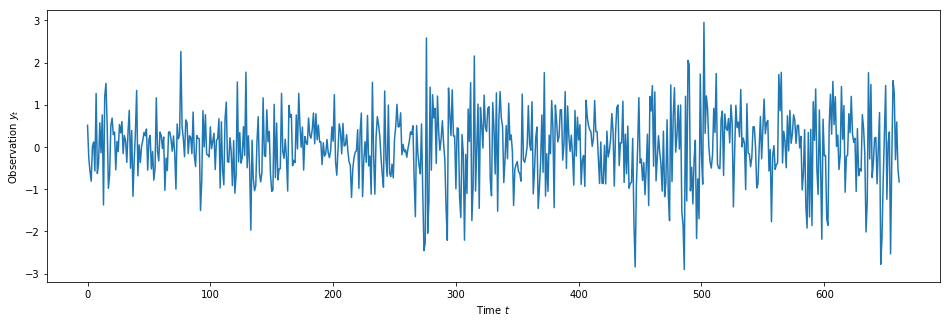

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load data
path = os.getcwd()
y = np.genfromtxt(path + '/OMXLogReturns.csv') 

# Plot observations
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(y)
ax.set_xlabel("Time $t$"); ax.set_ylabel("Observation $y_t$");
plt.show()

In [22]:
def bootstrap_particle_filter(y, N, theta, resampling=True):
    
    # Static parameters
    phi = theta[0] 
    sigma = theta[1] 
    beta = theta[2]
    
    # Initilialization
    T = len(y)
    logl = 0.0
    x = np.zeros([T+1, N])
    w = np.zeros([T+1, N])
    x[0, :] = np.random.normal(0.0, 1.0, size=N)
    w[0, :] = np.ones(N) / N
    
    for t in range(1, T+1):
        
        if resampling:
            x[t-1, :] = np.random.choice(x[t-1, :], N, p=w[t-1, :])
            
        x[t, :] = np.random.normal(loc=phi*x[t-1, :], scale=sigma, size=N)
        log_w_tilde = norm.logpdf(y[t-1], loc=0.0, scale=beta * np.exp(x[t,:] / 2) )
        
        # Compute log-liklihood with logsumexp trick
        max_w_tilde = np.max(log_w_tilde)
        log_w_tilde = log_w_tilde - max_w_tilde # subtract with maximum value of log weights
        logl += max_w_tilde + np.log(np.sum(np.exp(log_w_tilde))) - np.log(N)
        
        # normalize weights
        w[t, :] = np.exp(log_w_tilde) / np.sum(np.exp(log_w_tilde))                          
    return x, w, logl


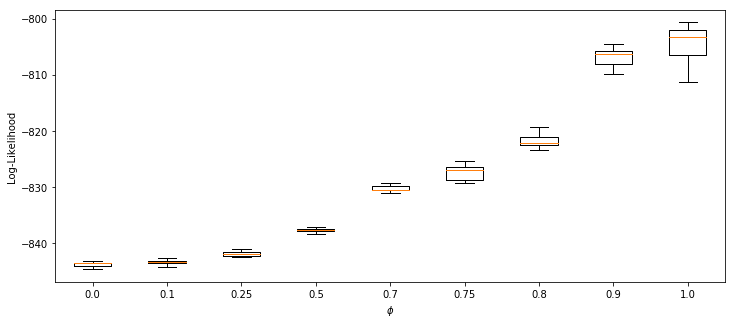

In [24]:
# Static parameters
Phi = [0.0, 0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.9, 1.0]
sigma = 0.16
beta = 0.7

n_runs = 10
logl_list = []
N = 100

for i, phi in enumerate(Phi):
    theta = [phi, sigma, beta]
    logl_phi = []
    for j in range(n_runs):
        x, w, logl = bootstrap_particle_filter(y, N, theta, resampling=True)
        logl_phi.append(logl)
    logl_list.append(logl_phi)

# Plot boxplot
phi_list = [str(phi) for phi in Phi]
fig, ax = plt.subplots(figsize=(12, 5))
ax.boxplot(logl_list, showfliers=False, labels=phi_list)
ax.set_xlabel(r"$\phi$"); ax.set_ylabel("Log-Likelihood"); 
plt.show()

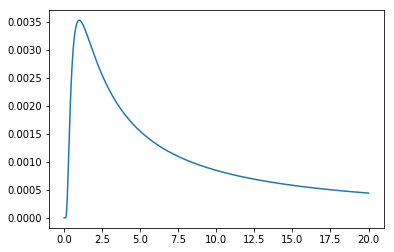

In [38]:
from scipy.special import gamma as gamma_function

def invgamma_pdf(x, a=0.01, b=0.01):
    return  b**(a) / gamma_function(a) * (x**(-a-1)) * np.exp(-1/x)

array = np.linspace(0.001,20, 1000)
plt.plot(array, invgamma_pdf(array, 0.01, 0.01))
plt.show()

In [ ]:
def gaussian_random_walk(x, scale=1.0):
    return np.random.normal(loc=x, scale=scale)

def particle_metropolis_hastings(y, M=10000, N=20):
    
    logl = np.zeros(M)
    theta_proposed = np.zeros([M,2]) # store sigma2, beta2
    theta = np.zeros([M,2]) # store sigma2, beta2
    phi = 0.985 # constant
    
    # Initialization
    theta[0, 0] = 1.0
    theta[0, 1] = 1.0
    theta_proposed[0,:] = theta[0,:]
    params = [phi, 1.0, 1.0]
    _, _, logl_proposed = bootstrap_particle_filter(y, N, theta=params)
    logl[0] = logl_proposed

    count = 0
    for m in range(1, M):
        
        # Draw sample from proposal distribution
        # Note that sigma2 and beta2 has to be positive!
        # Accept proposed samples when both are positive
        notfound = True
        while notfound:
            theta_proposed[m, :] = gaussian_random_walk(theta[m-1, :])
            theta_proposed[m, :] = np.abs(theta_proposed[m,:])
            if theta_proposed[m, 0] > 0.0 and theta_proposed[m, 1] > 0.0:
                notfound = False
        
        # Sample from uniform distribution
        u = np.random.uniform(0.0, 1.0)
        
        # Run BPF to get loglikelihood estimate
        params = [phi, np.sqrt(theta_proposed[m,0]), np.sqrt(theta_proposed[m,1])] 
        _, _, logl_proposed = bootstrap_particle_filter(y, N, theta=params)
        
        # Using gaussian random walk as proposal q should cancel out
        # when computing acceptance probability alpha
        logl_difference = logl_proposed - logl[m-1]
        
        # Compute log prior difference
        log_prior_sigma2 = np.log( invgamma_pdf(theta_proposed[m,0]) )
        log_prior_sigma2 = log_prior_sigma2 - np.log( invgamma_pdf(theta[m-1,0]) )
        log_prior_beta2 = np.log( invgamma_pdf(theta_proposed[m,1]) )
        log_prior_beta2 = log_prior_sigma2 - np.log( invgamma_pdf(theta[m-1,1]) )
        log_prior = log_prior_sigma2 + log_prior_beta2
        
        #print("logl_difference: ", logl_difference)
        #print("log_prior: ", log_prior)
        #print("accept prob: ", np.exp(logl_difference + log_prior))
        alpha = np.minimum(1.0, np.exp(logl_difference + log_prior) )
        if u <= alpha:
            theta[m, :] = theta_proposed[m, :]
            logl[m] = logl_proposed
        else:
            theta[m, :] = theta[m-1, :]
            logl[m] = logl[m-1] 
        if (m%100)==0:
            print("Number of samples ", m)
    return theta, logl

In [ ]:
M = 100 # number of samples from PMH
N = 10 # number of particles in BPF

theta, logl = particle_metropolis_hastings(y, M, N)



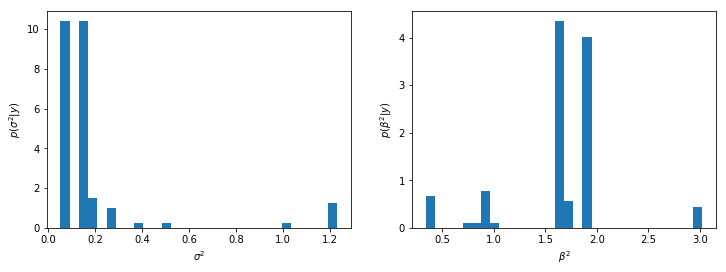

In [86]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].hist(theta[:,0], bins=30, density=True)
ax[0].set_xlabel(r"$\sigma^2$"); ax[0].set_ylabel(r"$p(\sigma^2 | y)$");
ax[1].hist(theta[:,1], bins=30, density=True)
ax[1].set_xlabel(r"$\beta^2$"); ax[1].set_ylabel(r"$p(\beta^2 | y)$");
plt.show()